<a href="https://colab.research.google.com/github/AndreyLFR/test/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22steel_fin_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты.


ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from zipfile import ZipFile
from imblearn.over_sampling import RandomOverSampler

#Готовим входные данные - фотографии из файла .zip

In [83]:
with ZipFile("/content/sample_data/train_images.zip", "r") as myzip:
    myzip.extractall(path='sever')

#Получаем данные по фотографиям, в том числе target

In [84]:
data = pd.read_csv('/content/sample_data/train.csv')

In [85]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


Наименования столбцов ImageID - наименование файла из архива, ClassID - target

In [86]:
data.shape

(7095, 3)

У нас 7095 и три фичи


# Разведочный анализ данных

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

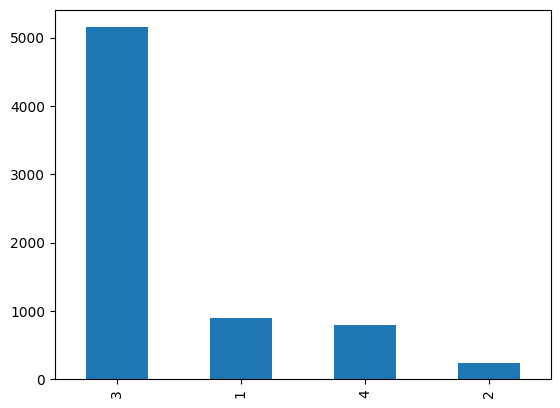

In [87]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [88]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
  image = cv2.imread(f'/content/sever/{img}', 1)
  if not image is None:
    image_rs=cv2.resize(image,(120,120))
    l1.append(image_rs)
    l2.append(ClassId)

print(len(l2))

100%|██████████| 7095/7095 [00:02<00:00, 2871.15it/s]

351


В папке 622 файла. При этом в csv файле у нас 7095 событий. Таким образом, удалось найти по наименованию файлов 351 событие.

Малая выборка может негативно отразиться на качестве обучения модели

#Выполним one-hot кодировку

In [89]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [90]:
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)
y = to_categorical(y)

#Разделим на тренировку и валидацию

In [91]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,stratify=y,shuffle=True)

In [92]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (885, 120, 120, 3)
x_test размер: (99, 120, 120, 3)
y_train размер: (885, 4)
y_test размер: (99, 4)


# Построение нейронной сети


In [93]:
model_1=Sequential()
model_1.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_1.add(Flatten())
model_1.add(Dense(4,activation="softmax"))


model_2=Sequential()
model_2.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3,3)))
model_2.add(Flatten())
model_2.add(Dense(256,activation="relu"))
model_2.add(Dense(4,activation="softmax"))

model_3=Sequential()
model_3.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_3.add(MaxPooling2D(pool_size=(3,3)))
model_3.add(Conv2D(64,(3,3),activation="relu"))
model_3.add(MaxPooling2D(pool_size=(3,3)))
model_3.add(Conv2D(64,(3,3),activation="relu"))
model_3.add(MaxPooling2D(pool_size=(4,4)))
model_3.add(Flatten())
model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(256,activation="relu"))
model_3.add(Dense(4,activation="softmax"))

In [94]:
i = 1
for model in [model_1, model_2, model_3]:
  print('------------------------------------------------')
  print(f'MODEL {i}')
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])
  history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)
  i+=1

------------------------------------------------
MODEL 1
Epoch 1/10
7/7 [==============================] - 2s 182ms/step - loss: 13.8415 - accuracy: 0.2972 - val_loss: 2.0006 - val_accuracy: 0.4848
Epoch 2/10
7/7 [==============================] - 0s 36ms/step - loss: 5.4272 - accuracy: 0.3853 - val_loss: 2.8268 - val_accuracy: 0.4848
Epoch 3/10
7/7 [==============================] - 0s 37ms/step - loss: 1.7927 - accuracy: 0.3751 - val_loss: 1.5211 - val_accuracy: 0.3030
Epoch 4/10
7/7 [==============================] - 0s 36ms/step - loss: 1.0849 - accuracy: 0.5333 - val_loss: 0.9296 - val_accuracy: 0.6465
Epoch 5/10
7/7 [==============================] - 0s 37ms/step - loss: 0.9137 - accuracy: 0.6090 - val_loss: 0.8942 - val_accuracy: 0.6162
Epoch 6/10
7/7 [==============================] - 0s 35ms/step - loss: 0.7991 - accuracy: 0.6904 - val_loss: 0.7388 - val_accuracy: 0.7374
Epoch 7/10
7/7 [==============================] - 0s 36ms/step - loss: 0.6213 - accuracy: 0.7751 - val_loss

#МОДЕЛЬ 1, несмотря на простоту показала наилучший результат
accuracy: 0.9333 - val_loss: 0.4809 - val_accuracy: 0.8687

ПРИМИМ ЭТО КАК БАЗУ ДЛЯ УЛУЧШЕНИЯ

#NEW MODEL

In [112]:
from keras import callbacks

model_new=Sequential()
model_new.add(Conv2D(128,(3,3),input_shape=(120,120,3),activation="relu"))
#model_new.add(MaxPooling2D(pool_size=(3,3)))
model_new.add(Flatten())
model_new.add(Dense(4,activation="softmax"))

model_new.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"])

callback1 = callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    mode='max', min_delta=0.001,
                    patience = 5)

history = model_new.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1, callbacks=[callback1])

Epoch 1/100
7/7 [==============================] - 2s 131ms/step - loss: 27.8349 - accuracy: 0.2904 - val_loss: 21.2690 - val_accuracy: 0.2525
Epoch 2/100
7/7 [==============================] - 1s 90ms/step - loss: 9.7537 - accuracy: 0.3412 - val_loss: 3.1465 - val_accuracy: 0.3636
Epoch 3/100
7/7 [==============================] - 1s 91ms/step - loss: 1.6287 - accuracy: 0.4712 - val_loss: 0.9360 - val_accuracy: 0.5758
Epoch 4/100
7/7 [==============================] - 1s 92ms/step - loss: 0.8500 - accuracy: 0.6486 - val_loss: 0.8474 - val_accuracy: 0.6263
Epoch 5/100
7/7 [==============================] - 1s 91ms/step - loss: 0.6953 - accuracy: 0.7571 - val_loss: 0.6358 - val_accuracy: 0.7778
Epoch 6/100
7/7 [==============================] - 1s 91ms/step - loss: 0.5404 - accuracy: 0.8011 - val_loss: 0.5578 - val_accuracy: 0.8081
Epoch 7/100
7/7 [==============================] - 1s 91ms/step - loss: 0.3994 - accuracy: 0.8904 - val_loss: 0.5537 - val_accuracy: 0.8485
Epoch 8/100
7/7 [

Благоприятно влияет:
1 увеличение количества эпох (EarlyStopping)
2

Негативно:

<Axes: title={'center': 'Loss curve'}>

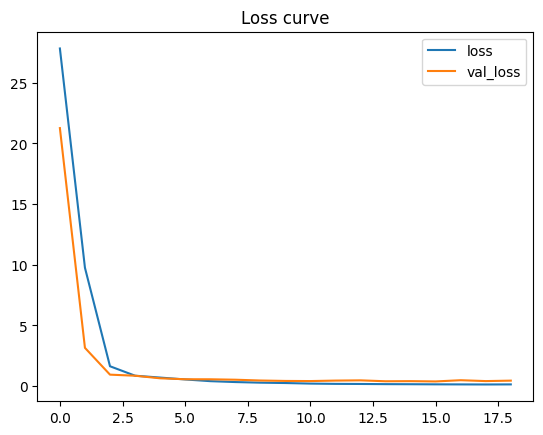

In [113]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

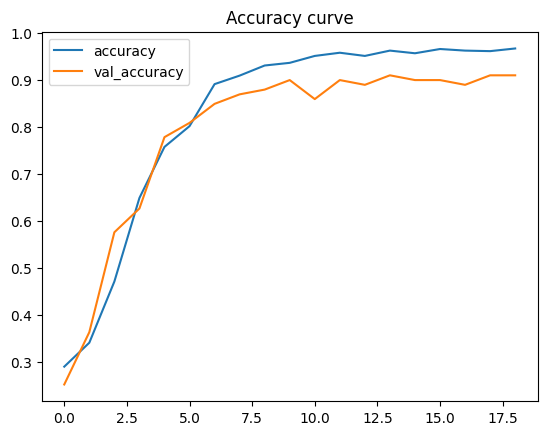

In [114]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [115]:
result = model_new.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

4/4 [==============================] - 0s 32ms/step - loss: 0.4422 - accuracy: 0.9091
[+] Accuracy: 90.91%


# Архитектура созданной нейронной сети

In [117]:
model_new.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 118, 118, 128)     3584      
                                                                 
 flatten_24 (Flatten)        (None, 1782272)           0         
                                                                 
 dense_40 (Dense)            (None, 4)                 7129092   
                                                                 
Total params: 7132676 (27.21 MB)
Trainable params: 7132676 (27.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.